# Youtube Title Classification Project
Adam Omarali <br>
2020-01-19

In [24]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

### Load Data

In [10]:
# import the data from local into the notebook

def get_data():
        return csv.reader(open("reviews.csv", 
                           "rt", encoding="latin-1"))

# Get the data into a dataframe 
df = pd.read_csv("reviews.csv") 

# Explore the head of the data 
df.head() 

,productiveunproductive,youtubetitle
0,1,Top 7 genius ideas.
1,0,Rare Video: Japan Tsunami | National Geographic
2,0,The Year the Earth Went Wild - Natural Disasters
3,0,Trevor Noah - Most Viewed Videos of 2019 (So Far)
4,1,The power of the placebo effect - Emma Bryce


### Tokenize the Data 


In [5]:
glove = torchtext.vocab.GloVe(name="6B",cache="/Users/mkayeungkwan/Desktop/glove.6B", dim=50)

# Create a function to split the title on punctuations and whitespaces. Feel free to add more punctuations to this list
def split_title(title):
    # separate punctuations
    title = title.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ") \
                 .replace("!", " ! ") \
                 .replace(":", " : ")
    return title.lower().split()

# Create a new column in the dataset that will hold the tokenized list of words 
tokens = [] 

for i in range(0,df.shape[0]):
    tokens.append(split_title(df["youtubetitle"][i]))
    
df["tokens"] = tokens
    
# Explore the table again

df.head(10)

,productiveunproductive,youtubetitle,tokens
0,1,Top 7 genius ideas.,"[top, 7, genius, ideas, .]"
1,0,Rare Video: Japan Tsunami | National Geographic,"[rare, video, :, japan, tsunami, |, national, ..."
2,0,The Year the Earth Went Wild - Natural Disasters,"[the, year, the, earth, went, wild, -, natural..."
3,0,Trevor Noah - Most Viewed Videos of 2019 (So Far),"[trevor, noah, -, most, viewed, videos, of, 20..."
4,1,The power of the placebo effect - Emma Bryce,"[the, power, of, the, placebo, effect, -, emma..."
5,1,The mysterious science of pain - Joshua W. Pate,"[the, mysterious, science, of, pain, -, joshua..."
6,1,Would you sacrifice one person to save five? -...,"[would, you, sacrifice, one, person, to, save,..."
7,1,How to make your writing funnier - Cheri Stein...,"[how, to, make, your, writing, funnier, -, che..."
8,1,How To Fall Asleep In 2 Minutes,"[how, to, fall, asleep, in, 2, minutes]"
9,0,Debunking the myths of OCD - Natascha M. Santos,"[debunking, the, myths, of, ocd, -, natascha, ..."


### Analyze the Data 

In [ ]:
# Analysis here
for i, line in enumerate(get_data()):
    print(line)



### Split the Data

In [14]:
def get_index(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):

        title = line[-1]
        idxs = [glove_vector.stoi[w]        # lookup the index of word
                for w in split_title(title)
                if w in glove_vector.stoi] # keep words that has an embedding
        if not idxs: # ignore titles without any word with an embedding
            continue
        idxs = torch.tensor(idxs) # convert list to pytorch tensor
        label = torch.tensor(int(line[0] == "1")).long()

        # Separating the data into train, test, val 
        if i % 5 < 3:
            train.append((idxs, label))
        elif i % 5 == 4:
            valid.append((idxs, label))
        else:
            test.append((idxs, label))
    return train, valid, test

train, valid, test = get_index(glove)
print("Shape of train,valid,test: ",len(train),len(valid),len(test))

Shape of train,valid,test:  600 200 200


### Neural Network Model

In [15]:
class YoutubeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(YoutubeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # 1. Look up the embedding of each word
        x = self.emb(x)
        # 2 . "Forward propagate" the RNN -- to compute hidden & output vectors
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        # 3. Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model = YoutubeRNN (50, 50, 2)

### Batching

In [21]:
# Just to show the code. We also initialize the data loaders down below.

train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)

### Get Accuracy Function 

Function that calculates how many of our predictions are right, giving us an accuracy score.

In [18]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for titles, labels in data_loader:
        output = model(titles)
        pred = output.max(1, keepdim=True)[1] # max value in the column
        # Gets a vector of the number of labels that equaled the prediction, sums the corrects, and item converts it into an integer
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Training Function

In [22]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss() # because we're doing multi-classification
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for titles, labels in train:
            optimizer.zero_grad()
            pred = model(titles)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        if ((epoch+1) % 5 ==0):
            print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                  epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Train the Model

Epoch 1; Loss 0.854965; Train Acc 0.703333; Val Acc 0.695000
Epoch 2; Loss 0.560992; Train Acc 0.800000; Val Acc 0.750000
Epoch 3; Loss 0.363420; Train Acc 0.821667; Val Acc 0.810000
Epoch 4; Loss 0.707548; Train Acc 0.823333; Val Acc 0.795000
Epoch 5; Loss 0.104479; Train Acc 0.836667; Val Acc 0.845000
Epoch 6; Loss 0.218125; Train Acc 0.825000; Val Acc 0.780000
Epoch 7; Loss 0.631250; Train Acc 0.858333; Val Acc 0.815000
Epoch 8; Loss 0.496687; Train Acc 0.868333; Val Acc 0.800000
Epoch 9; Loss 0.478145; Train Acc 0.875000; Val Acc 0.840000
Epoch 10; Loss 1.015036; Train Acc 0.881667; Val Acc 0.805000
Epoch 11; Loss 0.114827; Train Acc 0.898333; Val Acc 0.805000
Epoch 12; Loss 0.018168; Train Acc 0.905000; Val Acc 0.800000
Epoch 13; Loss 0.620957; Train Acc 0.920000; Val Acc 0.780000
Epoch 14; Loss 0.131045; Train Acc 0.935000; Val Acc 0.785000
Epoch 15; Loss 0.028602; Train Acc 0.941667; Val Acc 0.765000
Epoch 16; Loss 0.001691; Train Acc 0.950000; Val Acc 0.765000
Epoch 17; Loss 0.

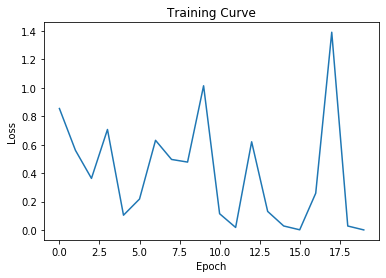

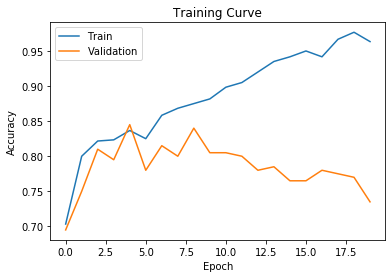

0.815

In [23]:
model = YoutubeRNN(input_size=50, hidden_size=50, num_classes=2)

train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
get_accuracy(model, test_loader)